# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

In [2]:
df = pd.read_excel('geo.xlsx', index_col=0)
df.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [3]:
df.describe()

,x,y,comment_class
count,108806.000000,108806.000000,108806.000000
mean,37.567532,55.766346,-0.748929
std,0.121996,0.069622,0.662653
min,37.148813,55.496939,-1.000000
25%,37.454528,55.729797,-1.000000
50%,37.559640,55.764734,-1.000000
75%,37.684784,55.806869,-1.000000
max,37.931228,55.994174,1.000000


In [4]:
df['comment_class'].value_counts()

-1    95147
 1    13659
Name: comment_class, dtype: int64

сильный дисбаланс comment_class, намного больше комментариев против

In [5]:
# from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation

In [6]:
X = df[['x', 'y']]
X

,x,y
0,37.612416,55.777454
1,37.612416,55.777454
2,37.603298,55.742108
3,37.558526,55.728758
4,37.566431,55.731794
...,...,...
108801,37.454528,55.792331
108802,37.384325,55.899068
108803,37.421066,55.848756
108804,37.448509,55.793065


 разделим город на районы

In [7]:
# допустим 6 районов
clf_kmeans = KMeans(n_clusters=6)

In [8]:
clusters = clf_kmeans.fit_predict(X)
clusters

array([3, 3, 3, ..., 1, 4, 1])

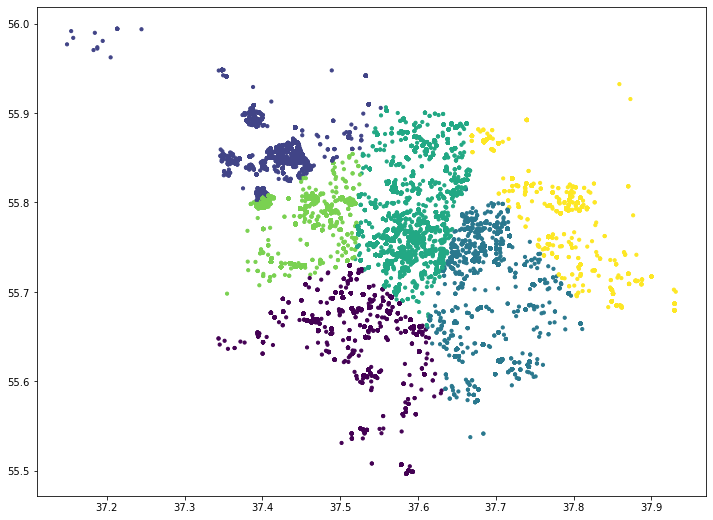

In [9]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters, s=10)

Посмотрим скопления голосов за и против на карте

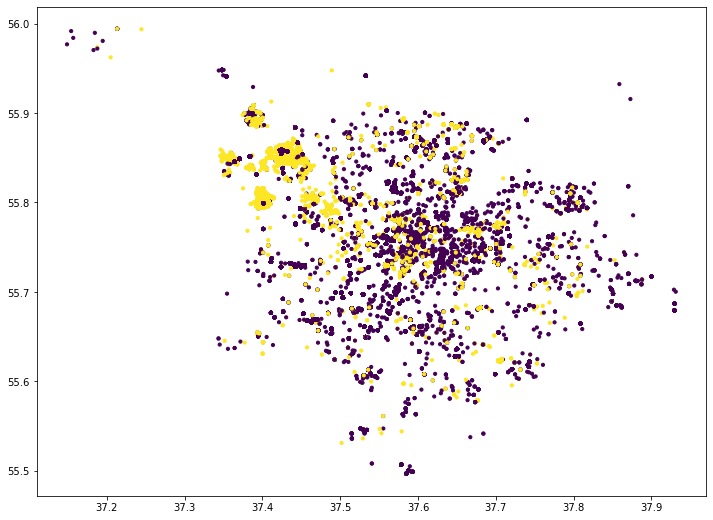

In [10]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=df['comment_class'], s=10)

подберем оптимальное число кластеров 

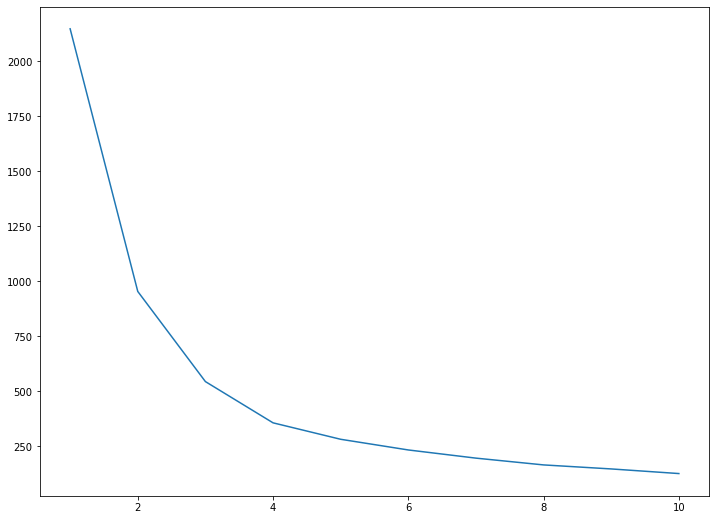

In [11]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X)
    k_inertia.append(clf_kmeans.inertia_)
    
plt.plot(ks, k_inertia)

In [12]:
diff = np.diff(k_inertia)
diff_r = diff[1:] / diff[:-1]

In [13]:
# оптимальное количество кластеров
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

In [14]:
clf_kmeans = KMeans(n_clusters=k_opt, 
                    n_init=1, 
                    init=np.array([[37.4, 55.85], [37.75, 55.7]]), 
                    max_iter=1, 
                    algorithm="auto", 
                    random_state=0)
clusters = clf_kmeans.fit_predict(X)

In [15]:
centers = clf_kmeans.cluster_centers_

In [16]:
clusters_random = np.random.randint(low=0, high=2, size=len(X))

Text(0.5, 1.0, 'Random')

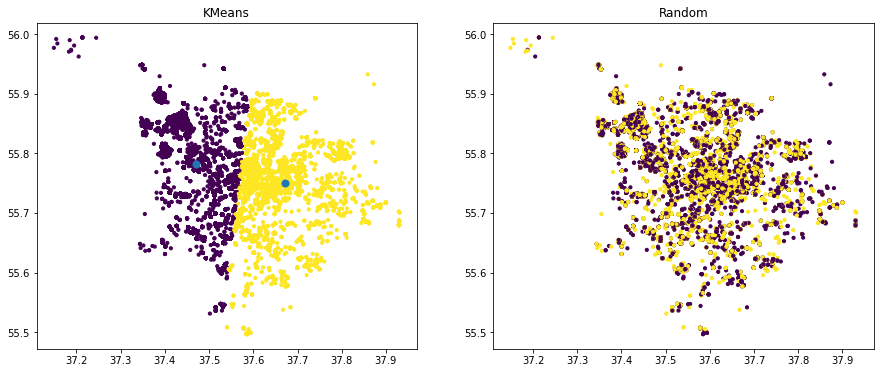

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters, s=10)
axes[0].scatter(centers[:, 0], centers[:, 1], s=50)
axes[0].set_title("KMeans")
axes[1].scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters_random, s=10)
axes[1].set_title("Random")

In [20]:
from sklearn.metrics import adjusted_rand_score

In [21]:
# метрика ARI для Kmeans
adjusted_rand_score(df['comment_class'], clusters)

0.026010690426550385

In [22]:
# метрика ARI для рандома
adjusted_rand_score(df['comment_class'], clusters_random)

-1.4579279443270168e-05

Метрика ARI для Kmeans хоть и низкая, но больше чем для рандома